In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [83]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [84]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [85]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [86]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [87]:
# Split the data into train, val, test (70-20-10)

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.6):int(n*0.8)]
test_df1 = first_piece[int(n*0.8):]


In [88]:
# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1
test_df1 = (test_df1 - train_mean1) / train_std1

In [89]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [90]:
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)
test_seq1, test_labels1 = create_sequences(test_df1.values, 12)

In [91]:
# Convert to PyTorch tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1)  # (batch, output_dim)
test_seq_tensor1 = torch.FloatTensor(test_seq1)  # (batch, seq_length, input_dim)
test_labels_tensor1 = torch.FloatTensor(test_labels1)  # (batch, output_dim)

In [92]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cpu")  # Use "cuda" if you have a GPU


In [93]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

In [94]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion(y_pred, train_label_tensor1)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9392134547233582, Val Loss: 5.626766204833984
Epoch 10, Train Loss: 0.11922173947095871, Val Loss: 0.5407928824424744
Epoch 20, Train Loss: 0.02769663743674755, Val Loss: 1.1267857551574707
Epoch 30, Train Loss: 0.022273605689406395, Val Loss: 0.49376848340034485
Epoch 40, Train Loss: 0.016592655330896378, Val Loss: 0.2759627103805542
Epoch 50, Train Loss: 0.014658158645033836, Val Loss: 0.23438426852226257
Epoch 60, Train Loss: 0.014036064967513084, Val Loss: 0.12412925064563751
Epoch 70, Train Loss: 0.013485805131494999, Val Loss: 0.10326606035232544
Epoch 80, Train Loss: 0.012976850382983685, Val Loss: 0.08625800162553787
Epoch 90, Train Loss: 0.012604519724845886, Val Loss: 0.054707758128643036


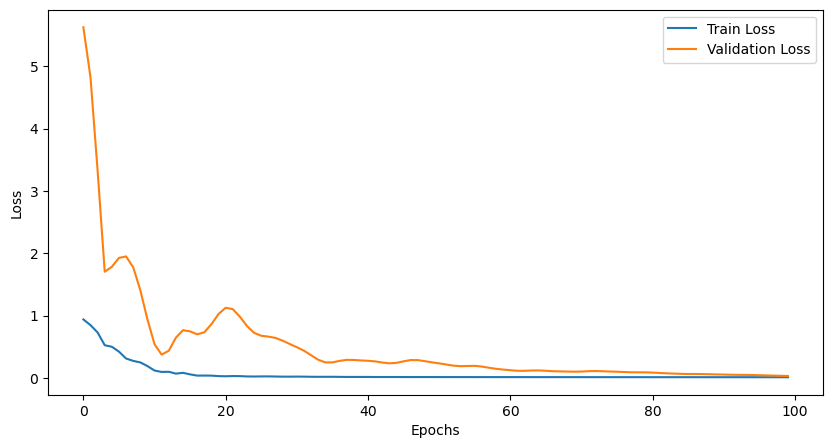

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


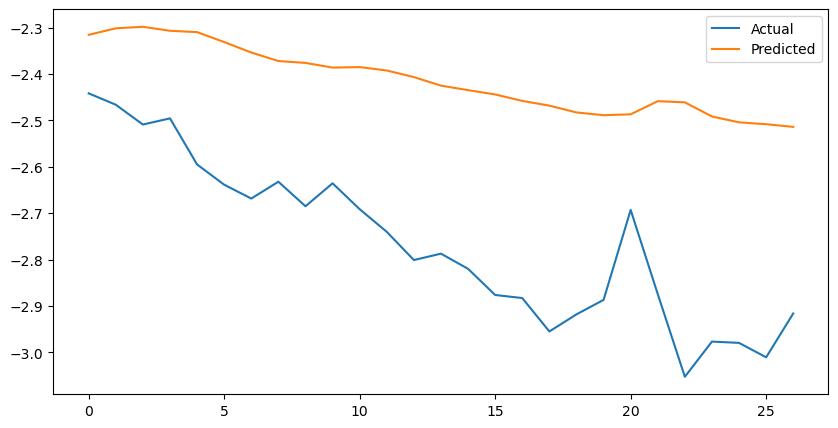

In [96]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [97]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.13580118119716644


In [98]:
test_seq_tensor1.shape

torch.Size([27, 12, 1])

In [99]:
np.concatenate((train_df1, val_df1, test_df1), axis=0).shape

(193, 1)

In [100]:
zeros = np.zeros((166,1))

In [101]:
y_pred_test.numpy().shape

(27, 1)

In [102]:
np.concatenate((zeros, y_pred_test.numpy()), axis=0)

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

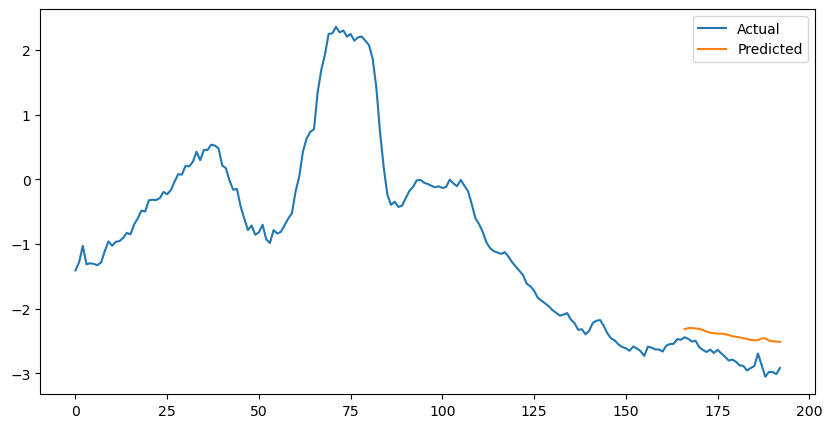

In [103]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df1, val_df1, test_df1), axis=0), label="Actual")
plt.plot(range(166, 193), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [104]:
column_indices = {name: i for i, name in enumerate(second_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.6)]
val_df2 = second_piece[int(n*0.6):int(n*0.8)]
test_df2 = second_piece[int(n*0.8):]

In [105]:
# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2
test_df2 = (test_df2 - train_mean2) / train_std2

In [106]:
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)
test_seq2, test_labels2 = create_sequences(test_df2.values, 12)
# Convert to PyTorch tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2)  # (batch, output_dim)
test_seq_tensor2 = torch.FloatTensor(test_seq2)  # (batch, seq_length, input_dim)
test_labels_tensor2 = torch.FloatTensor(test_labels2)  # (batch, output_dim)

In [107]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

In [108]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion(y_pred, train_label_tensor2)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 1.0015966892242432, Val Loss: 3.1984262466430664


Epoch 10, Train Loss: 0.14644187688827515, Val Loss: 0.8971548676490784
Epoch 20, Train Loss: 0.04188507795333862, Val Loss: 0.29699480533599854
Epoch 30, Train Loss: 0.029618896543979645, Val Loss: 0.11962420493364334
Epoch 40, Train Loss: 0.026873253285884857, Val Loss: 0.04136878624558449
Epoch 50, Train Loss: 0.024515796452760696, Val Loss: 0.03617798909544945
Epoch 60, Train Loss: 0.022715097293257713, Val Loss: 0.02928771823644638
Epoch 70, Train Loss: 0.020970728248357773, Val Loss: 0.039460133761167526
Epoch 80, Train Loss: 0.01970217004418373, Val Loss: 0.04280301555991173
Epoch 90, Train Loss: 0.02044297754764557, Val Loss: 0.045227594673633575


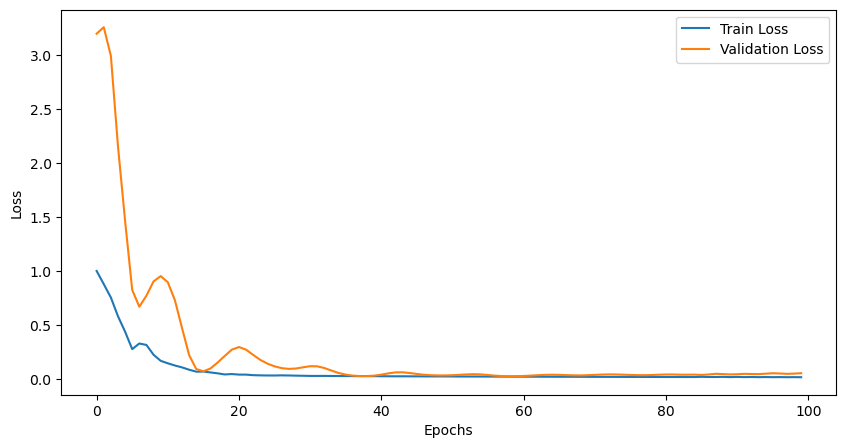

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


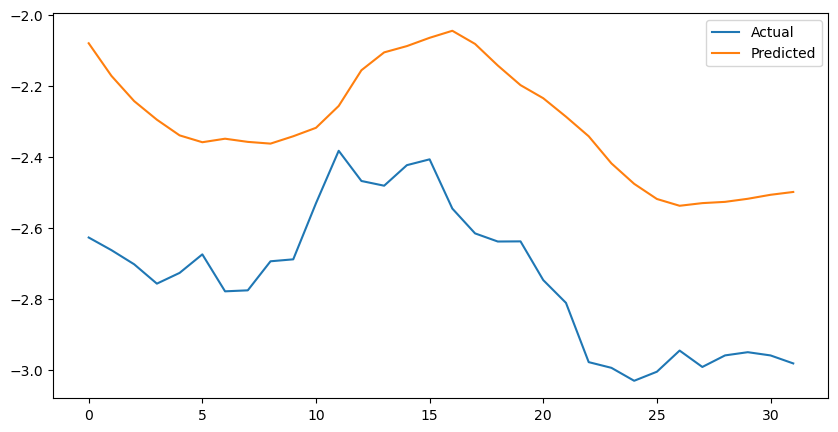

In [110]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [111]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.19784151017665863


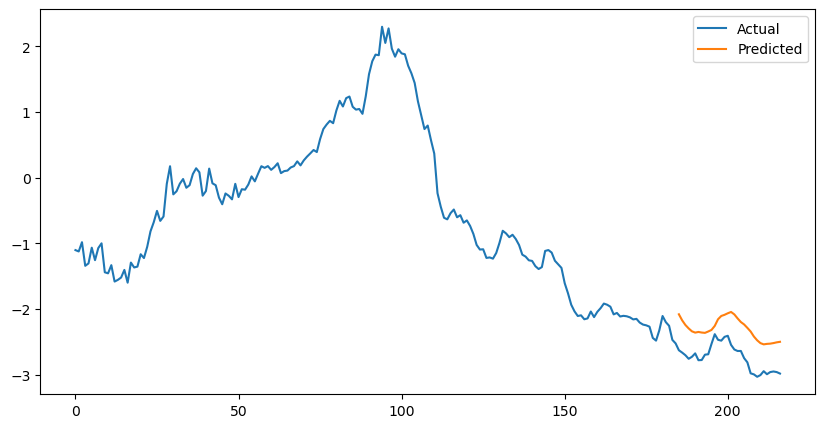

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df2, val_df2, test_df2), axis=0), label="Actual")
plt.plot(range(185, 217), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [113]:
column_indices = {name: i for i, name in enumerate(third_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.6)]
val_df3 = third_piece[int(n*0.6):int(n*0.8)]
test_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3
test_df3 = (test_df3 - train_mean3) / train_std3

train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)
test_seq3, test_labels3 = create_sequences(test_df3.values, 12)
# Convert to PyTorch tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3)  # (batch, output_dim)
test_seq_tensor3 = torch.FloatTensor(test_seq3)  # (batch, seq_length, input_dim)
test_labels_tensor3 = torch.FloatTensor(test_labels3)  # (batch, output_dim)

In [114]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)

In [115]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion(y_pred, train_label_tensor3)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9012293815612793, Val Loss: 0.3248884677886963
Epoch 10, Train Loss: 0.1818363517522812, Val Loss: 0.1380051225423813
Epoch 20, Train Loss: 0.06487684696912766, Val Loss: 0.0915469229221344
Epoch 30, Train Loss: 0.042433567345142365, Val Loss: 0.0487079955637455
Epoch 40, Train Loss: 0.026504166424274445, Val Loss: 0.021564297378063202
Epoch 50, Train Loss: 0.02127263881266117, Val Loss: 0.013486547395586967
Epoch 60, Train Loss: 0.018949249759316444, Val Loss: 0.01215266901999712
Epoch 70, Train Loss: 0.017897382378578186, Val Loss: 0.010340532287955284
Epoch 80, Train Loss: 0.017196455970406532, Val Loss: 0.009731202386319637
Epoch 90, Train Loss: 0.016553310677409172, Val Loss: 0.010447145439684391


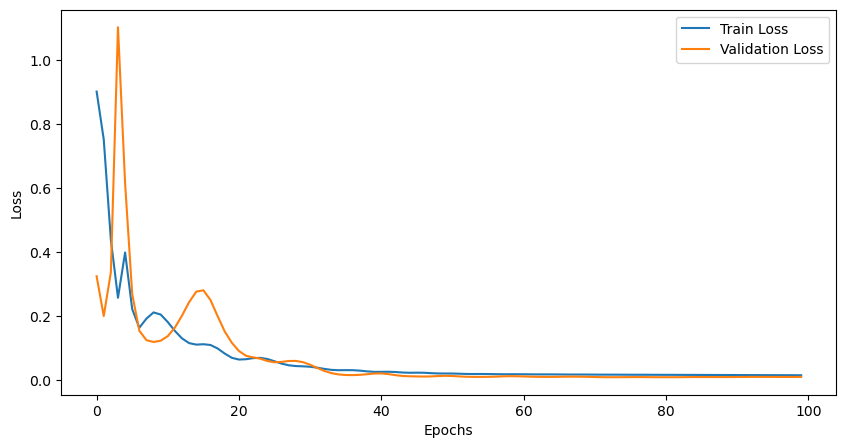

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


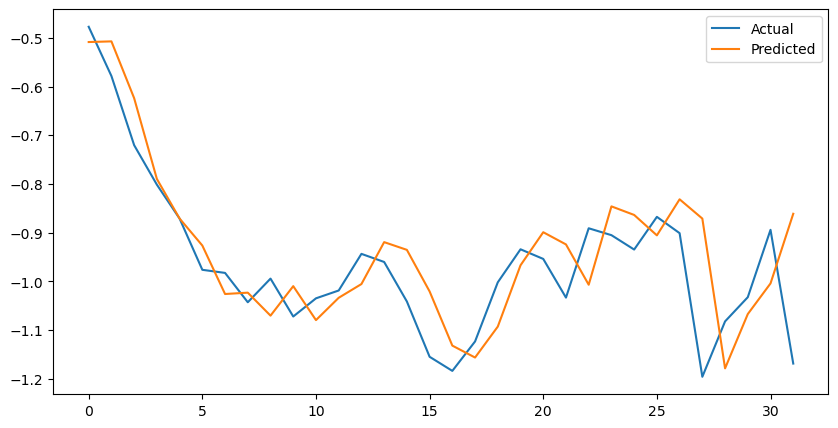

In [117]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [118]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.01080088410526514


In [119]:
len(y_pred_test.numpy())

32

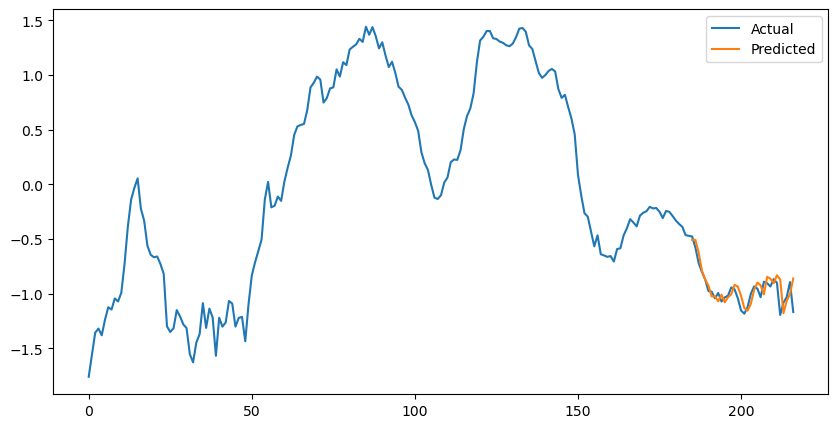

In [120]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df3, val_df3, test_df3), axis=0), label="Actual")
plt.plot(range(185, 217), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [121]:
column_indices = {name: i for i, name in enumerate(second_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.6)]
val_df4 = fourth_piece[int(n*0.6):int(n*0.8)]
test_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4
test_df4 = (test_df4 - train_mean4) / train_std4

train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)
test_seq4, test_labels4 = create_sequences(test_df4.values, 12)
# Convert to PyTorch tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4)  # (batch, output_dim)
test_seq_tensor4 = torch.FloatTensor(test_seq4)  # (batch, seq_length, input_dim)
test_labels_tensor4 = torch.FloatTensor(test_labels4)  # (batch, output_dim)

In [122]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model4 = model4.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.01)

In [123]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model4.train()
    
    optimizer.zero_grad()
    y_pred = model4(train_seq_tensor4)
    
    loss = criterion(y_pred, train_label_tensor4)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model4(val_seq_tensor4)
        val_loss = criterion(y_val, val_label_tensor4)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.6937110424041748, Val Loss: 2.4270565509796143
Epoch 10, Train Loss: 0.1416822373867035, Val Loss: 0.6301408410072327
Epoch 20, Train Loss: 0.05863931030035019, Val Loss: 0.15562036633491516
Epoch 30, Train Loss: 0.032682135701179504, Val Loss: 0.07904856652021408
Epoch 40, Train Loss: 0.021938897669315338, Val Loss: 0.06708133965730667
Epoch 50, Train Loss: 0.016812726855278015, Val Loss: 0.06565450876951218
Epoch 60, Train Loss: 0.015568810515105724, Val Loss: 0.03811357170343399
Epoch 70, Train Loss: 0.014465829357504845, Val Loss: 0.04273250699043274
Epoch 80, Train Loss: 0.013649861328303814, Val Loss: 0.058202553540468216
Epoch 90, Train Loss: 0.012996440753340721, Val Loss: 0.057872507721185684


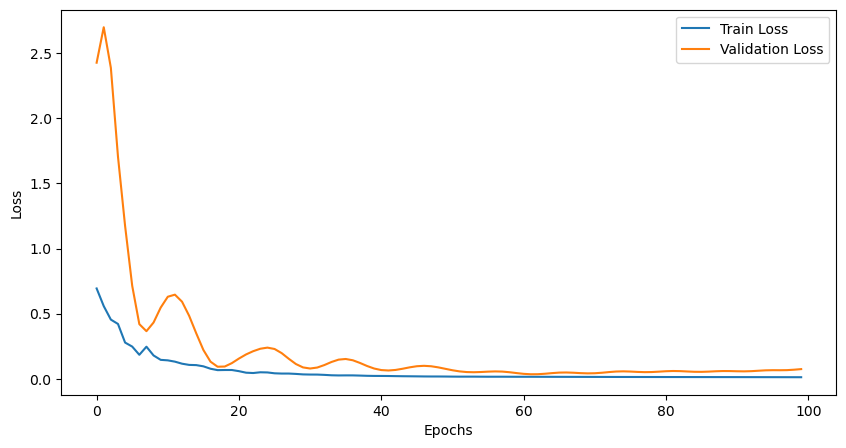

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


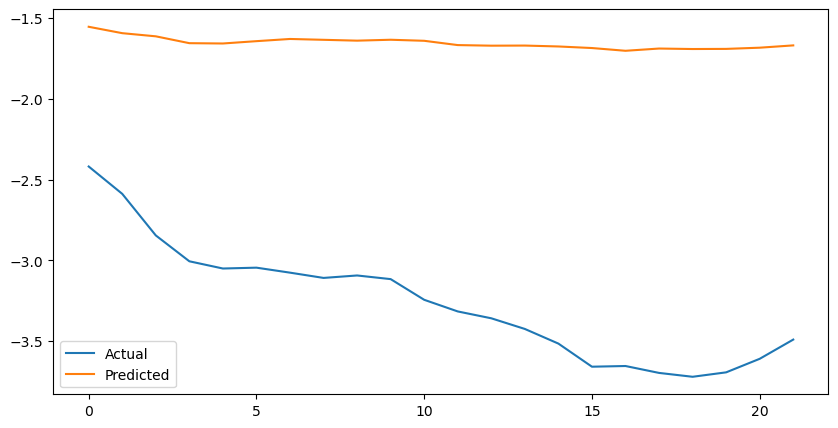

In [125]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [126]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 2.6786391735076904


In [127]:
len(y_pred_test.numpy())

22

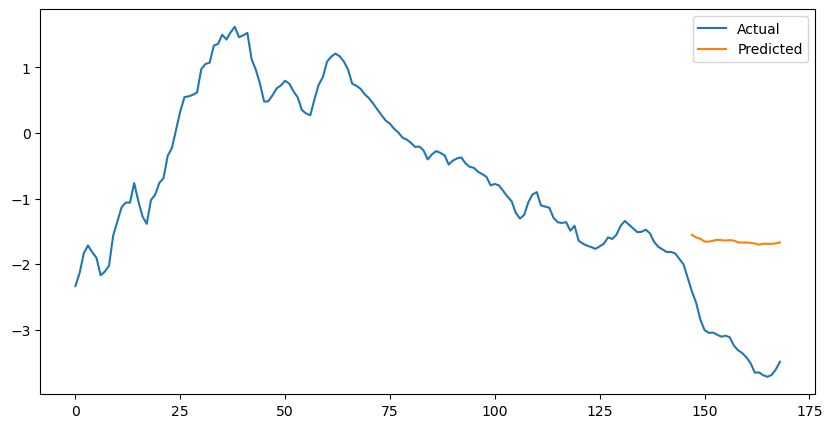

In [128]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df4, val_df4, test_df4), axis=0), label="Actual")
plt.plot(range(147, 169), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

### Model 1 on other 3 pieces

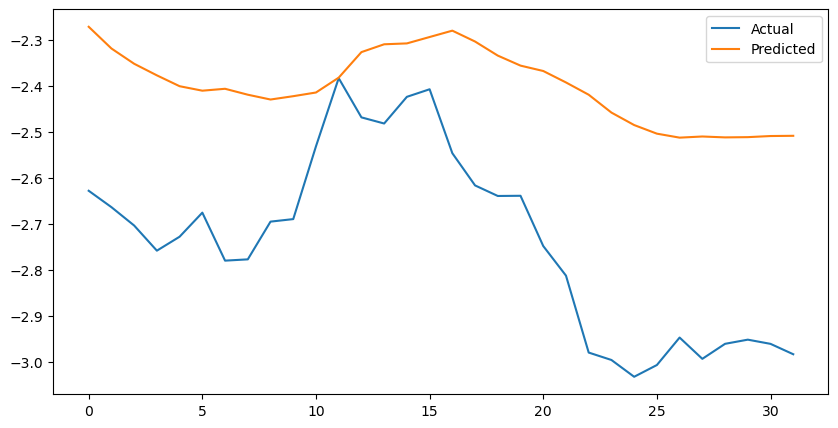

In [129]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [130]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.13279162347316742


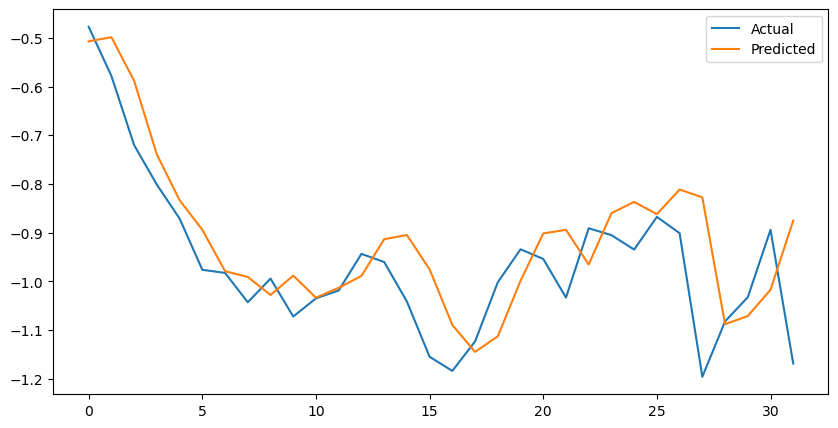

In [131]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [132]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.012936625629663467


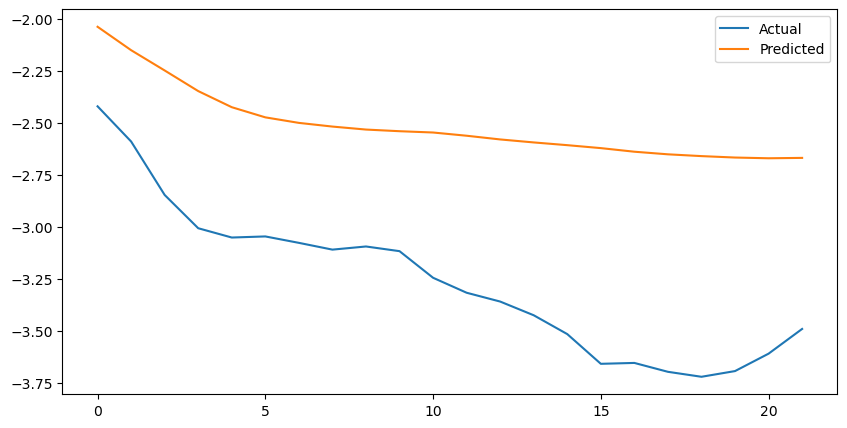

In [133]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [134]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.6048208475112915


### Model 2 on 3 other pieces

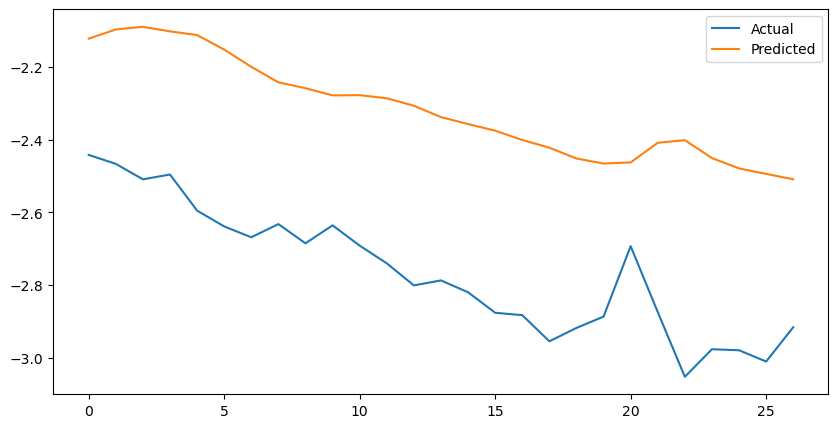

In [135]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [136]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.20683929324150085


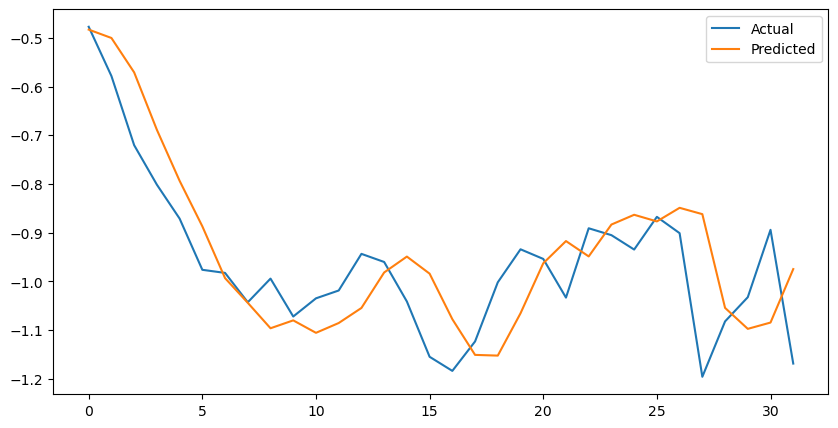

In [137]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [138]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.012279117479920387


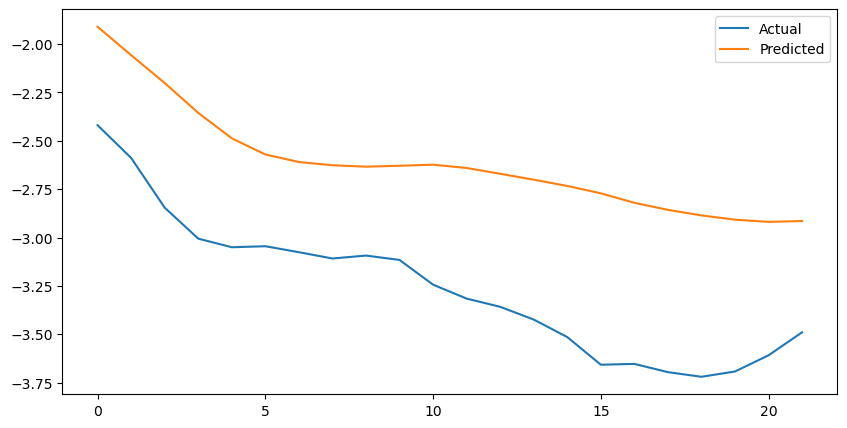

In [139]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [140]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.43472129106521606


### Model 3 on other pieces

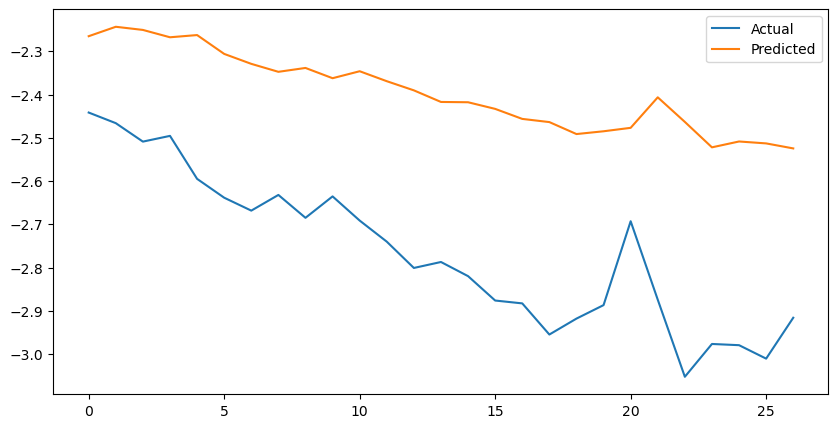

In [141]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [142]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.14596310257911682


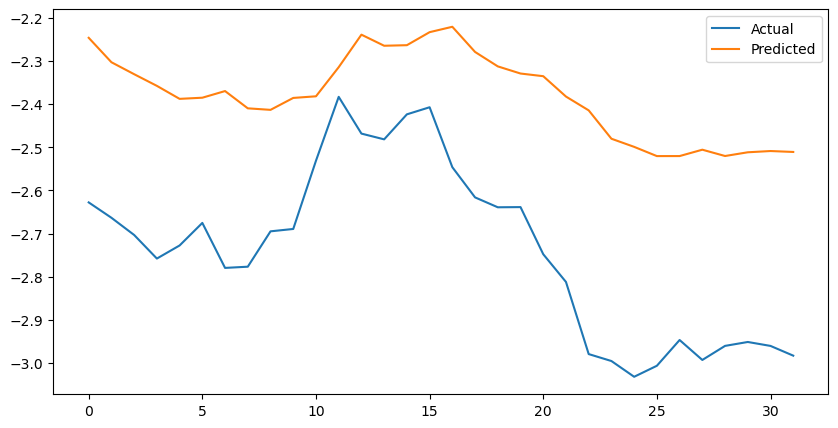

In [143]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [144]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.1419157236814499


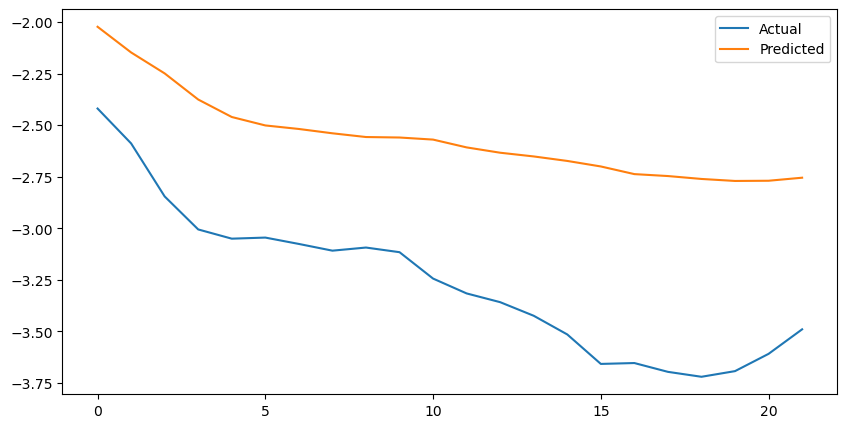

In [145]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [146]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.5196857452392578


### Model 4 on other 3 pieces

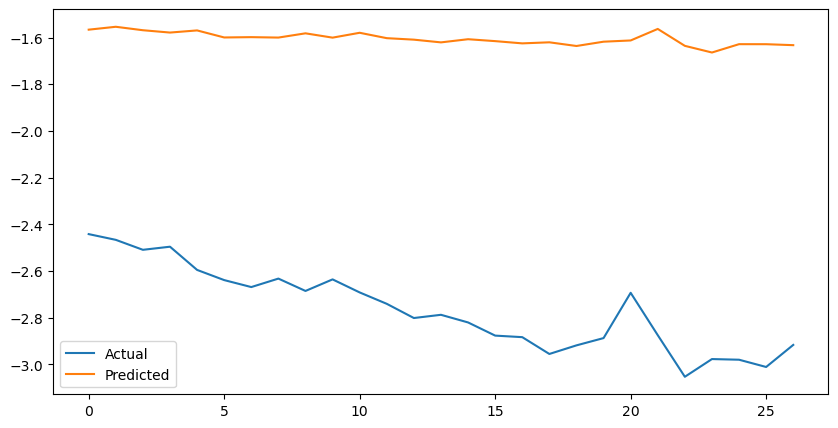

In [147]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [148]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 1.3685166835784912


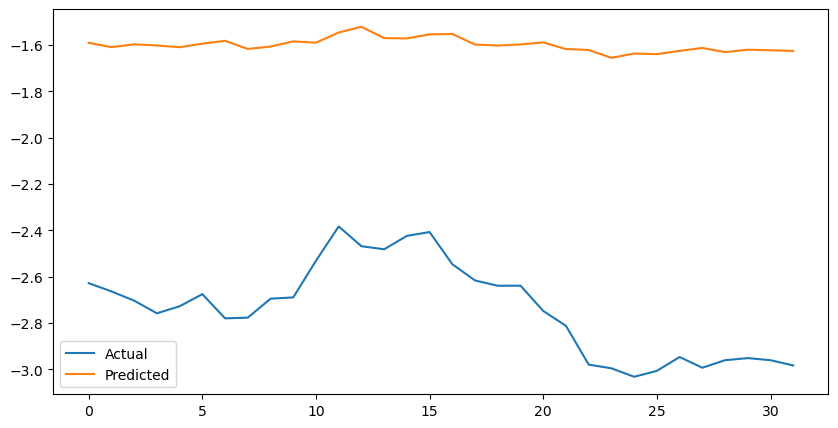

In [149]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [150]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 1.3224282264709473


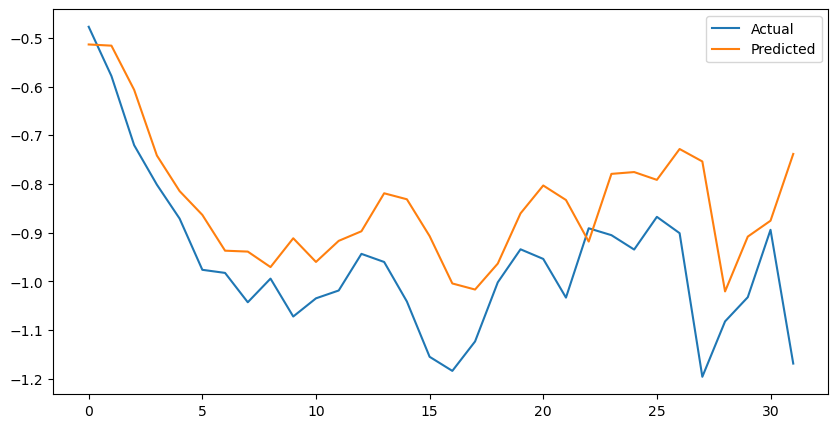

In [151]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [152]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.025343269109725952


In [153]:
import copy

### Now let's average all the models

In [154]:
average_model = copy.deepcopy(model1)
models = [model1, model2, model3, model4]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters

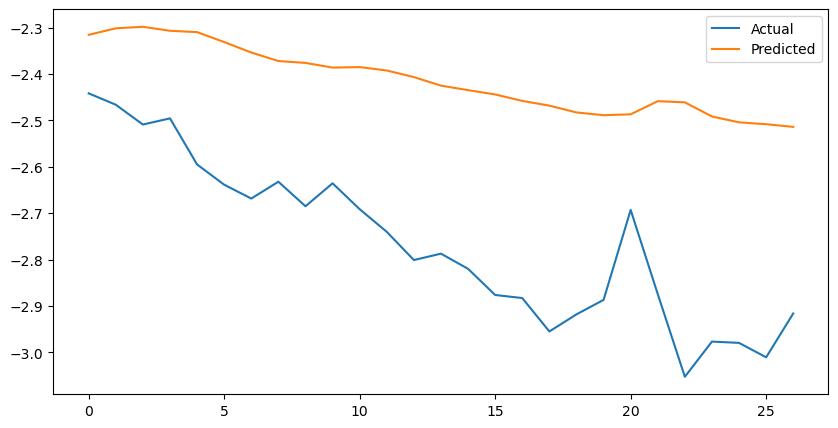

In [155]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [156]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.13580118119716644


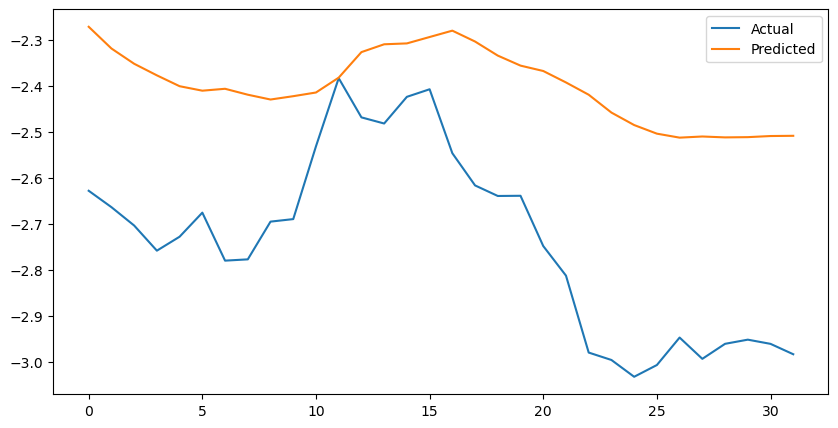

In [157]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [158]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.13279162347316742


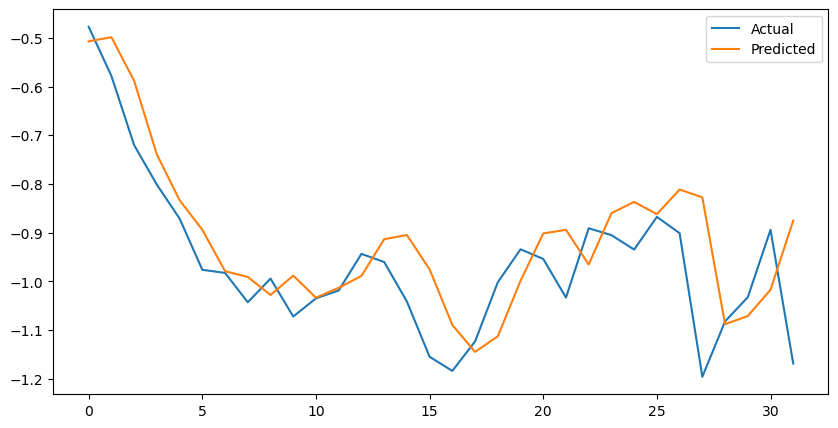

In [159]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [160]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.012936625629663467


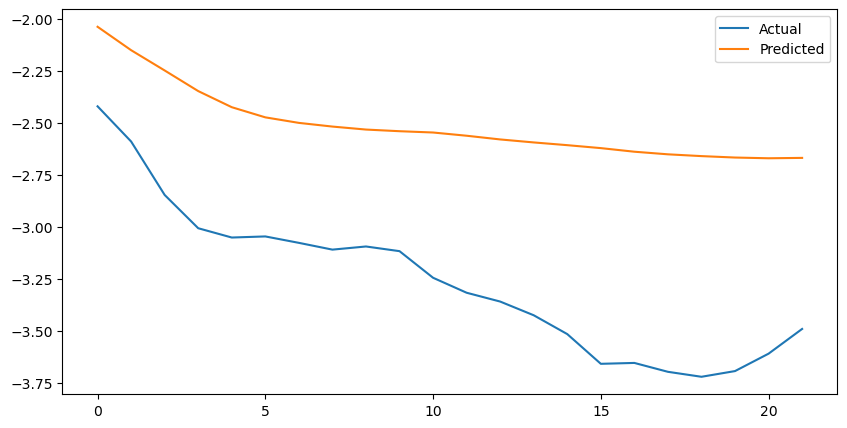

In [161]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [162]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.6048208475112915
